In [1]:
import os
import datetime

import numpy as np
import scipy
import fiona
import statistics
import math

import pandas as pd
import geopandas as gpd
from shapely.geometry import LineString, shape, mapping, Point, Polygon, MultiPolygon
from shapely.ops import cascaded_union

import matplotlib.pyplot as plt
from matplotlib import colors, cm, style
import matplotlib.patches as mpatches
from descartes import PolygonPatch

import osmnx as ox
import networkx as nx

In [2]:
from my_osm import get_osm_data
from my_isochrones import get_isochrones

In [3]:
style.use('seaborn-white')
output_folder = 'data'
osm_crs = 'EPSG:3857'

# Parameters

In [4]:
# Place                                Country              CRS
# Amsterdam | Rotterdam | The Hague    (The Netherlands)    EPSG:28992
# Madrid    | Barcelona | Valencia     (Spain)              EPSG:25830
# Stockholm | Goteborg  | Malmo        (Sweden)             EPSG:3006 ???

place_name = 'The Hague'
local_crs = 'EPSG:28992'
place_extra = 0

In [5]:
trip_distances = [300, 500, 800]
trip_colors = ['#78c679', '#c2e699', '#ffffcc']
buffer = max(trip_distances)

# 1 hectare equals 10000 square meters
min_area = 5000
threshold = 0

tolerance = 10

# Load data

In [6]:
place = ox.geocode_to_gdf(place_name).to_crs(local_crs)
if place_extra:
    place['geometry'] = place.buffer(place_extra, join_style=2)

extent = place.buffer(buffer, join_style=2)
if len(extent) > 1:
    extent_shape = MultiPolygon([shape(part) for part in extent.to_crs('EPSG:4326')])     
else:
    extent_shape = extent.to_crs('EPSG:4326')[0]

In [7]:
# custom filter: using the osmnx network_type 'walk' as a basis,
# but NOT excluding 'cycleways'.
# see https://github.com/gboeing/osmnx/blob/main/osmnx/downloader.py
# and https://github.com/gboeing/osmnx/issues/169
network_filter = (
        f'["highway"]["area"!~"yes"]["access"!~"private"]'
        f'["highway"!~"abandoned|bus_guideway|construction|motor|planned|platform|proposed|raceway"]'
        f'["foot"!~"no"]["service"!~"private"]'
    )

In [8]:
G = ox.graph_from_polygon(extent_shape, network_type='walk', custom_filter=network_filter, retain_all=True)
G = ox.project_graph(G, to_crs=local_crs)

In [9]:
g_leisure_tag_query = '["leisure"~"^(park|nature_reserve)"]'
greenery = get_osm_data(g_leisure_tag_query, extent, 'convexhull')

In [10]:
# excluding: allotments, flowerbed, farmland, farmyard, orchards, vineyard, plant_nursary (i.e. crop production, not for entering)
g_landuse_tag_query = '["landuse"~"^(forest|meadow|grass|village_green)"]'
greenery = greenery.append(get_osm_data(g_landuse_tag_query, extent, 'convexhull'))

In [11]:
g_natural_tag_query = '["natural"~"^(wood|scrub|heath|grassland|fell|shrubbery)"]'
greenery = greenery.append(get_osm_data(g_natural_tag_query, extent, 'convexhull'))

Response <Response [429]>
Waiting 30sec, and trying again max 4 more times


In [12]:
# all buildings with or without any tags
b_tag_query = '[building]'
buildings = get_osm_data(b_tag_query, extent, 'convexhull')

In [13]:
# all buildings with a residential tag
# following https://wiki.openstreetmap.org/wiki/Key:building residential, but without: hotel, terrace
r_tag_query_incl = '["building"~"^(apartments|bungalow|cabin|detached|dormitory|farm|ger|house|houseboat|residential|semidetached_house|static_caravan)"]'
residences_incl = get_osm_data(r_tag_query_incl, extent, 'convexhull')

In [14]:
# all buildings with no tags or a residential tag
# i.e. combining the previous query with a query for unknown building types
r_tag_query_unkn = '["building"="yes"]'
residences_non_excl = get_osm_data(r_tag_query_unkn, extent, 'convexhull')
residences_non_excl = residences_non_excl.append(residences_incl)

Response <Response [504]>
Waiting 30sec, and trying again max 4 more times


# Simplify network graph

In [15]:
if tolerance > 0:
    G2 = ox.consolidate_intersections(G, rebuild_graph=True, tolerance=tolerance, dead_ends=True, reconnect_edges=True)
    print("After consolidating intersections with tolerance {}, {} out of {} nodes remain ({} %).".format(tolerance, len(G2), len(G), (round(100*len(G2)/len(G), 1))))
G = G2

After consolidating intersections with tolerance 10, 23433 out of 48094 nodes remain (48.7 %).


In [16]:
if tolerance > 0:
    paths = ox.utils_graph.graph_to_gdfs(ox.get_undirected(G2), nodes=False, edges=True).to_crs(local_crs)
else:
    paths = ox.utils_graph.graph_to_gdfs(ox.get_undirected(G), nodes=False, edges=True).to_crs(local_crs)
paths.reset_index(drop=True, inplace=True)

In [17]:
if tolerance > 0:
    nodes = ox.utils_graph.graph_to_gdfs(G2, nodes=True, edges=False).to_crs(local_crs)
else:
    nodes = ox.utils_graph.graph_to_gdfs(G, nodes=True, edges=False).to_crs(local_crs)
nodes.reset_index(drop=True, inplace=True)

In [18]:
nodes['_geom'] = nodes.geometry

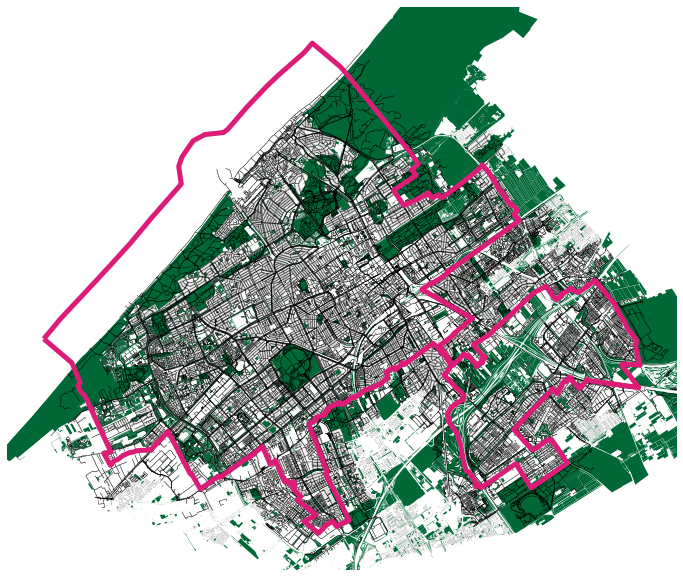

In [19]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(12,12))

greenery.plot(ax=axs, figsize=(12, 12), color='#006837', alpha=1, zorder=1)
residences_incl.plot(ax=axs, figsize=(12, 12), color='grey')
paths.plot(ax=axs, figsize=(12, 12), color='black', linewidth=0.5, zorder=3)
place.plot(ax=axs, figsize=(12, 12), facecolor='none', edgecolor='#dd1c77', linestyle='-', linewidth=5, zorder=4)

bbox = place.total_bounds
margin = 1000
xlim = ([bbox[0]-margin, bbox[2]+margin])
ylim = ([bbox[1]-margin, bbox[3]+margin])
axs.set_xlim(xlim)
axs.set_ylim(ylim)
plt.axis('off')

plt.show()

# Filter greenspaces

In [20]:
def greenspace_filter(gdf, local_crs,
                      threshold=0, place=None, min_area=10000, G=None):
    """
    gdf = geoseries of greenery polygons (e.g. greenery.geometry)
    return = a union of filtered polygons
    [optional] threshold to merge spaces in proximity (in meters)
    [optional] place geoseries of total area geometries (e.g. place_gdf.geometry)
    [optional] minimum area for greenspace filter, default value set
    [optional] graph which greenspace should intersect nodes and edges of
    """
    
    filtered = gdf.copy()
    
    # only polygons, no points or lines
    filtered = filtered[(filtered.geom_type == 'Polygon')|(filtered.geom_type == 'MultiPolygon')]
    
    #union of adjacent and overlapping polygons
    filtered['geometry'] = filtered.buffer(threshold)
    filtered = gpd.GeoDataFrame(filtered.unary_union).rename(columns={0:'geometry'}).set_geometry('geometry').set_crs(local_crs)
    filtered['geometry'] = filtered.buffer(-threshold)

    # filter on intersect with place
    if place is not None:
        filtered = gpd.sjoin(filtered, gpd.GeoDataFrame(place.geometry), how="left", predicate='within')
        filtered = filtered[filtered.index_right.notnull()].drop(columns=['index_right'])
        
    # filter on minimum area
    if min_area > 0:
        filtered = filtered[filtered.geometry.area>=min_area]
    
    # filter on intersection with network
    if G:
        edges = ox.utils_graph.graph_to_gdfs(G, nodes=False, edges=True)
        filtered = gpd.sjoin(filtered, gpd.GeoDataFrame(edges.reset_index(drop=True).geometry), how="left", predicate='intersects')
        filtered = filtered[filtered.index_right.notnull()].drop(columns=['index_right'])
        
        nodes = ox.utils_graph.graph_to_gdfs(G, nodes=True, edges=False)
        filtered = gpd.sjoin(filtered, gpd.GeoDataFrame(nodes.reset_index(drop=True).geometry), how="left", predicate='intersects')
        filtered = filtered[filtered.index_right.notnull()].drop(columns=['index_right'])

    filtered.drop_duplicates(inplace=True)
    return filtered

In [21]:
# greenspaces = greenspace_filter(greenery, local_crs, threshold=threshold, place=place, min_area=min_area, G=G)
greenspaces = greenspace_filter(greenery, local_crs, threshold=threshold, place=place, min_area=min_area, G=G)
'{} greenspaces fulfil the criteria for filtering'.format(len(greenspaces))

'169 greenspaces fulfil the criteria for filtering'

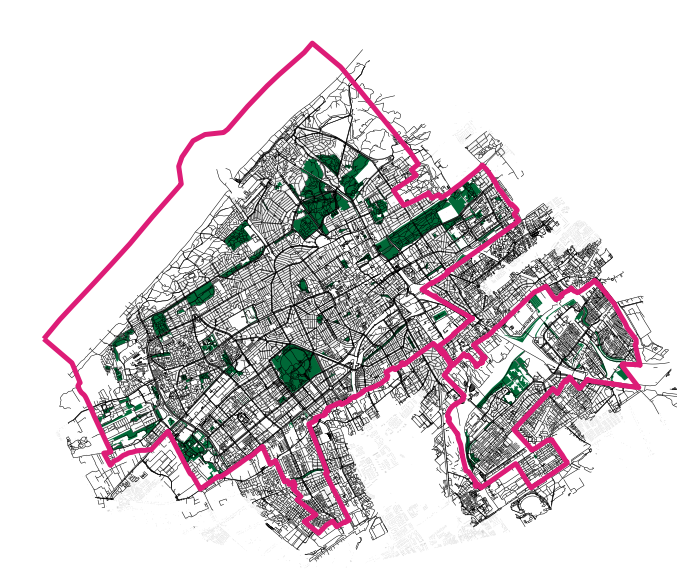

In [22]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(12,12))

greenspaces.plot(ax=axs, figsize=(12, 12), color='#006837', alpha=1, zorder=2)
residences_incl.plot(ax=axs, figsize=(12, 12), color='lightgrey')
paths.plot(ax=axs, figsize=(12, 12), color='black', linewidth=0.5, zorder=3)
place.plot(ax=axs, figsize=(12, 12), facecolor='none', edgecolor='#dd1c77', linestyle='-', linewidth=5, zorder=4)

bbox = place.total_bounds
margin = 1000
xlim = ([bbox[0]-margin, bbox[2]+margin])
ylim = ([bbox[1]-margin, bbox[3]+margin])
axs.set_xlim(xlim)
axs.set_ylim(ylim)
plt.axis('off')

plt.show()

## Isochrones

In [23]:
get_isochrones(G, greenspaces, trip_distances, local_crs)

In [24]:
trip_labels = []
for trip_distance in trip_distances:
    trip_labels.append('Within {}m walk'.format(trip_distance))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


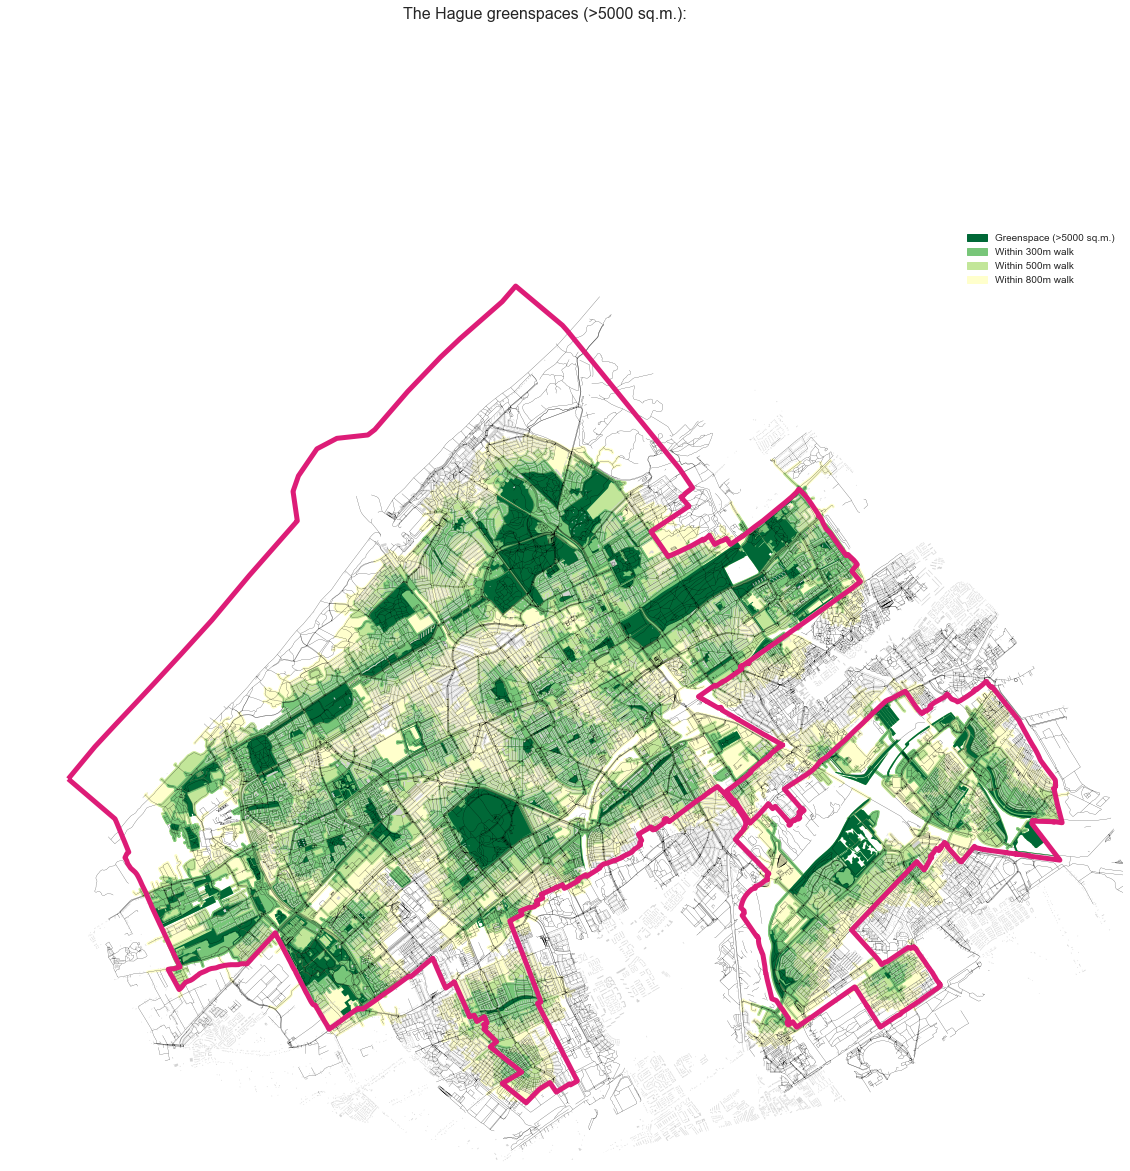

In [25]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(20,20))
fig.suptitle('{0} greenspaces (>{1} sq.m.): '.format(place_name, min_area), fontsize=16)

for i in range(len(trip_distances)):
    greenspaces.set_geometry(('geom_iso_'+str(trip_distances[i]))).plot(ax=axs, color=trip_colors[i], zorder=len(trip_distances)-i)
greenspaces.plot(ax=axs, figsize=(12, 20), color='#006837', zorder=4)
residences_incl.plot(ax=axs, figsize=(12, 12), color='lightgrey', zorder=5)
paths.plot(ax=axs, figsize=(12, 20), color='black', linewidth=0.2, zorder=5)
place.plot(ax=axs, figsize=(12, 12), facecolor='none', edgecolor='#dd1c77', linestyle='-', linewidth=5, zorder=6)

gs = mpatches.Patch(color='#006837', label='Greenspace (>{} sq.m.)'.format(min_area))
handles = [gs]
for i in range(len(trip_distances)):
    handles.append(mpatches.Patch(color=trip_colors[i], label=trip_labels[i]))
plt.legend(loc='upper right')
plt.legend(handles=handles)

bbox = place.total_bounds
margin = 1000
xlim = ([bbox[0]-margin, bbox[2]+margin])
ylim = ([bbox[1]-margin, bbox[3]+margin])
axs.set_xlim(xlim)
axs.set_ylim(ylim)
plt.axis('off')

plt.show()

In [26]:
# possible improvement: introduce nodes where edges intersect with greenspace border, i.e. entrances

#  Store output data

In [27]:
place_name_out = place_name.split(',')[0].replace(' ', '')
today = datetime.date.today().strftime("%d%b%Y")
output_sub_folder = os.path.join(output_folder, '{}_{}'.format(place_name_out, today))

In [28]:
if not os.path.exists(output_sub_folder):
    os.mkdir(output_sub_folder)

In [29]:
output_file = os.path.join(output_sub_folder, 'greenery.geojson')
greenery = greenery.apply(lambda c: c.astype(str) if c.name != "geometry" else c, axis=0)
greenery.to_file(output_file, driver='GeoJSON')

In [30]:
output_file = os.path.join(output_sub_folder, 'greenspaces.geojson')
greenspaces = greenspaces.apply(lambda c: c.astype(str) if c.name != "geometry" else c, axis=0)
greenspaces.to_file(output_file, driver='GeoJSON')

In [31]:
output_file = os.path.join(output_sub_folder, 'paths.geojson')
paths = paths.apply(lambda c: c.astype(str) if c.name != "geometry" else c, axis=0)
paths.to_file(output_file, driver='GeoJSON')

In [32]:
output_file = os.path.join(output_sub_folder, 'buildings.geojson')
buildings = buildings.apply(lambda c: c.astype(str) if c.name != "geometry" else c, axis=0)
buildings.to_file(output_file, driver='GeoJSON')

In [33]:
output_file = os.path.join(output_sub_folder, 'residences_incl.geojson')
residences_incl = residences_incl.apply(lambda c: c.astype(str) if c.name != "geometry" else c, axis=0)
residences_incl.to_file(output_file, driver='GeoJSON')

In [34]:
output_file = os.path.join(output_sub_folder, 'residences_non_excl.geojson')
residences_non_excl = residences_non_excl.apply(lambda c: c.astype(str) if c.name != "geometry" else c, axis=0)
residences_non_excl.to_file(output_file, driver='GeoJSON')

In [35]:
output_file = os.path.join(output_sub_folder, 'place.geojson')
place = place.apply(lambda c: c.astype(str) if c.name != "geometry" else c, axis=0)
place.to_file(output_file, driver='GeoJSON')

In [36]:
output_file = os.path.join(output_sub_folder, 'G.graphml')
ox.save_graphml(G, output_file)